In [5]:
import kagglehub
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, hamming_loss

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
path = kagglehub.dataset_download("PromptCloudHQ/imdb-data")
files = os.listdir(path)
csv_file_path = os.path.join(path, 'IMDB-Movie-Data.csv')
data = pd.read_csv(csv_file_path)
print(data.columns)
print(data['Title'][1])
print(data['Genre'][1])
print(data['Description'][1])


Index(['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year',
       'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)',
       'Metascore'],
      dtype='object')
Prometheus
Adventure,Mystery,Sci-Fi
Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.


In [8]:
stop_words = set(stopwords.words('english'))
print(stop_words)
lemmatizer = WordNetLemmatizer()
tokens = nltk.word_tokenize(data['Description'][1].lower())
print(tokens)
filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens
if token not in stop_words and token.isalnum()]
print(filtered_tokens)

{'ours', "mustn't", "shan't", "wouldn't", 'had', "you're", 'theirs', 'over', "it's", 'because', 'more', 'by', "don't", 'other', 'of', 'about', 'but', "you've", 'it', 'itself', 'will', 'their', 'your', 'any', 'they', 'some', 'she', 'does', 'and', 'off', "needn't", 'again', 're', 'yours', "mightn't", 'under', "won't", "wasn't", 'd', 'shan', 'you', 'whom', 'where', 'than', 'should', 'mightn', 'm', 'before', 'i', 'all', 'as', "shouldn't", 'he', 'or', 'which', 'll', "you'd", 'how', 'after', 'him', 'isn', 'themselves', 'not', 'y', 'those', 'a', "she's", 'to', 'myself', 'once', 'same', 'being', 'this', 'o', 'on', 'weren', 'both', 'further', 'did', 'couldn', "isn't", 'into', 'only', 'no', "aren't", 'herself', 'her', 'me', 'through', 've', 'do', 'shouldn', 'own', "couldn't", "weren't", 'until', "you'll", 'can', 'ma', 'these', 'doing', 'needn', 'have', 'his', 'we', 'are', 'won', 'if', 'such', 'very', 'just', 'hadn', 'was', 'having', 'has', 's', "hadn't", "that'll", 'now', 'been', "didn't", 'down

In [9]:
def filter_tokens(description):
    tokens = nltk.word_tokenize(description.lower())
    filtered_tokens = [
        lemmatizer.lemmatize(token) for token in tokens
        if token not in stop_words and token.isalnum()
    ]
    return filtered_tokens


In [10]:
data['Description_Filtered'] = data['Description'].apply(filter_tokens)

In [11]:
data['Description_Filtered']

,Description_Filtered
0,"[group, intergalactic, criminal, forced, work,..."
1,"[following, clue, origin, mankind, team, find,..."
2,"[three, girl, kidnapped, man, diagnosed, 23, d..."
3,"[city, humanoid, animal, hustling, theater, im..."
4,"[secret, government, agency, recruit, dangerou..."
...,...
995,"[team, rising, investigator, along, supervisor..."
996,"[three, american, college, student, studying, ..."
997,"[romantic, spark, occur, two, dance, student, ..."
998,"[pair, friend, embark, mission, reunite, pal, ..."


In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

--2024-11-14 20:41:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-14 20:41:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-14 20:41:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [13]:
data['embeddings'] = data['Description_Filtered'].apply(lambda x: [embeddings_index[word] for word in x if word in embeddings_index])

In [14]:
genres = data['Genre'].apply(lambda x: x.split(','))
print(genres)
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(genres)
data['Genre_Binarized'] = data['Genre'].apply(lambda x: mlb.transform([x.split(',')]))
print(mlb.classes_)

0       [Action, Adventure, Sci-Fi]
1      [Adventure, Mystery, Sci-Fi]
2                [Horror, Thriller]
3       [Animation, Comedy, Family]
4      [Action, Adventure, Fantasy]
                   ...             
995         [Crime, Drama, Mystery]
996                        [Horror]
997         [Drama, Music, Romance]
998             [Adventure, Comedy]
999       [Comedy, Family, Fantasy]
Name: Genre, Length: 1000, dtype: object
['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']


In [15]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, input_shape=(20, 100)))
rnn_model.add(Dense(20, activation = 'sigmoid'))  # Output layer


rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
X = data['embeddings']
X_padded = pad_sequences(X, maxlen=20, padding='post', dtype='float32')
y = np.array(data['Genre_Binarized'].tolist())  # Adjust this based on your DataFrame structure
y = np.squeeze(y)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_padded, y, test_size=200)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=100)


I decided to use Hamming Loss for my accuracy metric. After doing some research on why my accuracy was so low, I realized accuracy_score is strict in terms of multi-class classification because it requires an exact match. Since each movie can belong in multiple genres, if the model does not predict the exact combination of genres, it is counted as wrong. Whereas in Hamming Loss, each label is checked for accuracy independently, so predicting one of the genres is better than predicting none of them at all. In this sense, it is more forgiving when it comes to multi-class classification, especially in this context.

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.2034 - loss: 0.3110 - val_accuracy: 0.2000 - val_loss: 0.3126
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2250 - loss: 0.3116 - val_accuracy: 0.2000 - val_loss: 0.3126
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2099 - loss: 0.3106 - val_accuracy: 0.2000 - val_loss: 0.3126
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2094 - loss: 0.3125 - val_accuracy: 0.2000 - val_loss: 0.3128
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2121 - loss: 0.3131 - val_accuracy: 0.2000 - val_loss: 0.3123
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1827 - loss: 0.3106 - val_accuracy: 0.2000 - val_loss: 0.3128
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2164 - loss: 0.3080 - val_accuracy: 0.2100 - val_loss: 0.3129
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2188 - loss: 0.3091 - val_accuracy: 0.2000 - val_loss

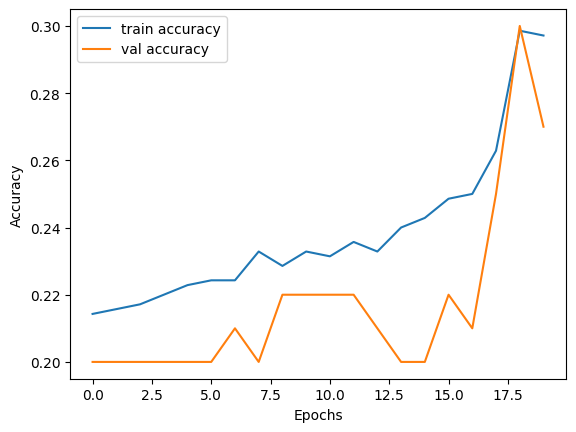

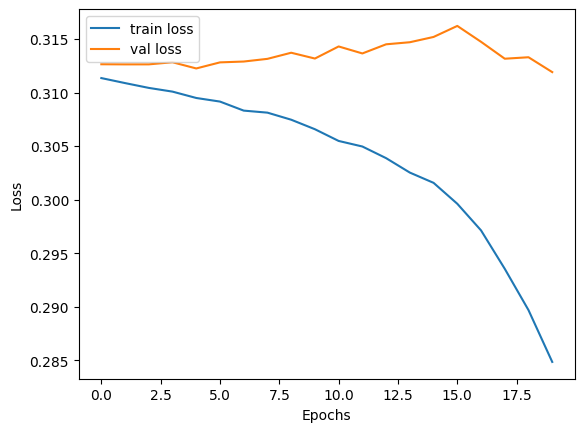

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.87425


In [26]:
history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Plotting the training and validation accuracy/loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred_prob = rnn_model.predict(X_test)
#using threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

hamming_acc = 1 - hamming_loss(y_test, y_pred)

print("Accuracy:", hamming_acc)


For the RNN model, we get an accuracy of 0.874.

In [18]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(20, 100)))
lstm_model.add(Dense(20, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4404 - loss: 0.2448 - val_accuracy: 0.3600 - val_loss: 0.2335
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4428 - loss: 0.2299 - val_accuracy: 0.4200 - val_loss: 0.2284
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4758 - loss: 0.2166 - val_accuracy: 0.4100 - val_loss: 0.2334
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4582 - loss: 0.2143 - val_accuracy: 0.3500 - val_loss: 0.2340
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4869 - loss: 0.2068 - val_accuracy: 0.3800 - val_loss: 0.2326
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4841 - loss: 0.2002 - val_accuracy: 0.4100 - val_loss: 0.2344
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5110 - loss: 0.1941 - val_accuracy: 0.3900 - val_loss: 0.2363
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5076 - loss: 0.1958 - val_accuracy: 0.4000 - val_loss

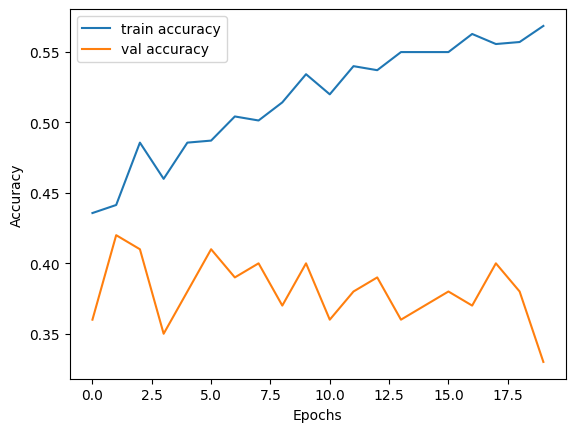

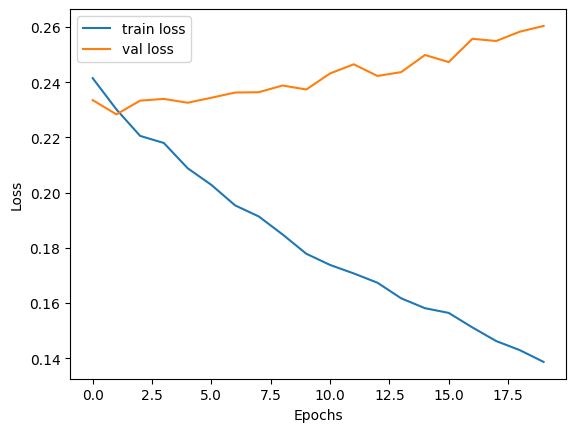

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.896


In [27]:
lstm = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


plt.plot(lstm.history['accuracy'], label='train accuracy')
plt.plot(lstm.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(lstm.history['loss'], label='train loss')
plt.plot(lstm.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred_prob = lstm_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

hamming_acc = 1 - hamming_loss(y_test, y_pred)


print("Accuracy:", hamming_acc)




For the LSTM model, we get an accuracy of 0.896

In [28]:
data['Title_tokenized'] = data['Title'].apply(lambda x: word_tokenize(x.lower()))

In [29]:
data["Title_embed"] = data['Title_tokenized'].apply(lambda x: [embeddings_index[word] for word in x if word in embeddings_index])

In [30]:
data['combined_embeddings'] = data.apply(lambda row: row['Title_embed'] + row['embeddings'], axis=1)

In [31]:
X = data['combined_embeddings']
X_padded = pad_sequences(X, maxlen=25, padding='post', dtype='float32')
y = np.array(data['Genre_Binarized'].tolist())  # Adjust this based on your DataFrame structure
y = np.squeeze(y)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_padded, y, test_size=200)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=100)

In [32]:
rnn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_train_val, y_train_val))

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2922 - loss: 0.2917 - val_accuracy: 0.2837 - val_loss: 0.2896
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3081 - loss: 0.2890 - val_accuracy: 0.2637 - val_loss: 0.2945
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2889 - loss: 0.2901 - val_accuracy: 0.2937 - val_loss: 0.2848
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3058 - loss: 0.2823 - val_accuracy: 0.2988 - val_loss: 0.2817
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2845 - loss: 0.2835 - val_accuracy: 0.2925 - val_loss: 0.2803
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3218 - loss: 0.2781 - val_accuracy: 0.3113 - val_loss: 0.2771
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3365 - loss: 0.2776 - val_accuracy: 0.3050 - val_loss: 0.2775
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3115 - loss: 0.2730 - val_accuracy: 0.3075 - v

In [34]:
y_pred_prob = rnn_model.predict(X_test)

y_pred_rnn = (y_pred_prob > 0.5).astype(int)

hamming_acc_rnn = 1 - hamming_loss(y_test, y_pred_rnn)


print("Accuracy:", hamming_acc_rnn)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.87875


For the RNN model that had the title embeddings added, the accuracy is now 0.87875. To recall, without the title embeddings, the accuracy was 0.87425. So we see a very small, minimal increase in the accuracy when title embeddings are included in the text descriptions.